<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:2px;border-top:4px solid #FF8200" />


# Adaptive Fourier Filtering


part of 

<font size = "4"> **pyTEMlib**, a **pycroscopy** library </font>


Notebook by 

Gerd Duscher

Materials Science & Engineering<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville


An introduction into Fourier Filtering of images.


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q

# pyTEMlib setup ------------------
else:
    if test_package('sidpy') < '0.0.7':
        print('installing sidpy')
        !{sys.executable} -m pip install  --upgrade sidpy -q     
    if test_package('pyNSID') < '0.0.3':
        print('installing pyNSID')
        !{sys.executable} -m pip install  --upgrade pyNSID -q 
    if test_package('pyTEMlib') < '0.2022.10.1':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

installing pyTEMlib
done


## Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [1]:
%pylab  notebook
sys.path.insert(0,'../../')
sys.path.insert(1,'../../../ScifiReaders')


import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools as it

print('pyTEMlib version: ', pyTEMlib.__version__)
note_book_version = '2021.10.25'
note_book_name='pyTEMib/notebooks/Imaging/Adaptive_Fourier_Filter'

Populating the interactive namespace from numpy and matplotlib
DimensionType.TEMPORAL
pyTEMlib version:  0.2021.10.2


## Open File

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

First we select the file

In [2]:
file_widget = ft.FileWidget()

Select(description='Select file:', layout=Layout(width='70%'), options=('.',), rows=10, value='.')

<IPython.core.display.Javascript object>


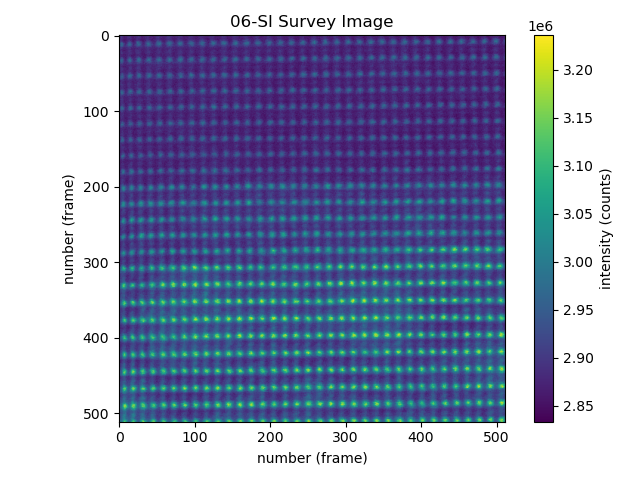

sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(512, 512), dtype=uint32, chunksize=(512, 512), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  number (frame) of size (512,)
y:  number (frame) of size (512,)

In [7]:
import SciFiReaders
reader = SciFiReaders.DM3Reader(file_widget.file_name)
d = reader.read()
d.x.dimension_type='SPATIAL'
d.y.dimension_type='SPATIAL'
d.plot()
d

In [8]:
34*.309


10.506

In [11]:
file_widget.file_name

'C:\\Users\\gdusc\\OneDrive - University of Tennessee\\2020 Experiment\\Chenze-ZrO2-movies\\5-12.5_ to 13.2_, 0.1_ increment 5 photos each, align.dm3'

Now, we open and plot them

C:\Users\gdusc\OneDrive - University of Tennessee\2020 Experiment\Elijah-EELS\a1_ 410s.dm3
Cannot overwrite file. Using:  a1_ 410s-7.hf5
We really would need an image here


C:\Users\gdusc\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


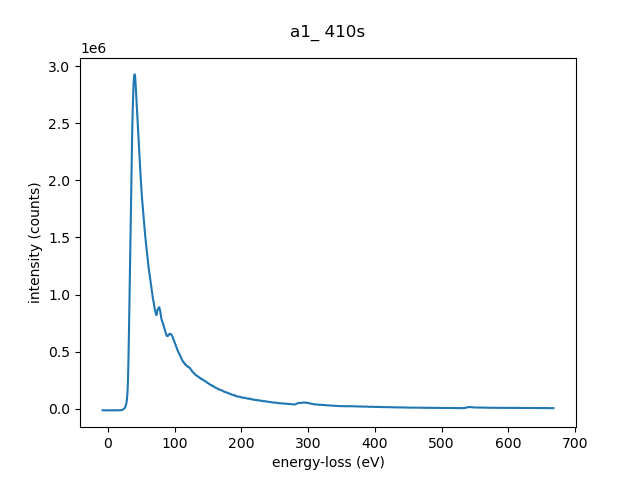

In [3]:
file_name = file_widget.file_name
print(file_name)
try:
    dataset.h5_dataset.file.close()
except:
    pass
dataset= ft.open_file(file_name)
if dataset.data_type.name != 'IMAGE':
    print('We really would need an image here')

dataset.plot()

## Power Spectrum of Image

fft :
	smoothing : 1
	minimum_intensity : 0.05816151649086299
	maximum_intensity : 1.7483518890871648
source:  NionReader


<IPython.core.display.Javascript object>


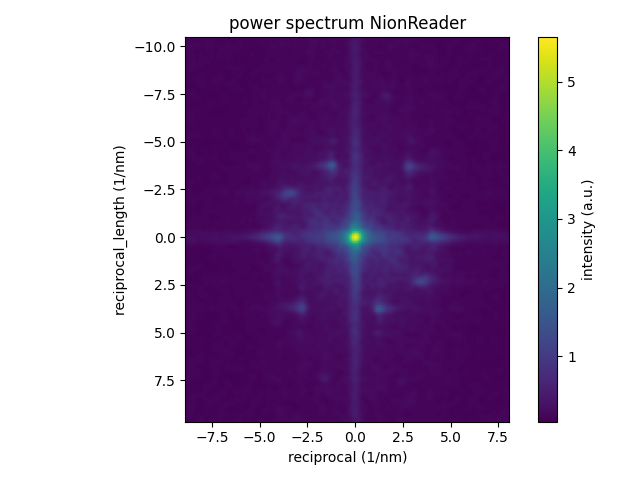

In [8]:
power_spectrum = it.power_spectrum(dataset, smoothing=1)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
power_spectrum.plot()

## Spot Detection in Fourier Transform

Found 9 reflections


<IPython.core.display.Javascript object>


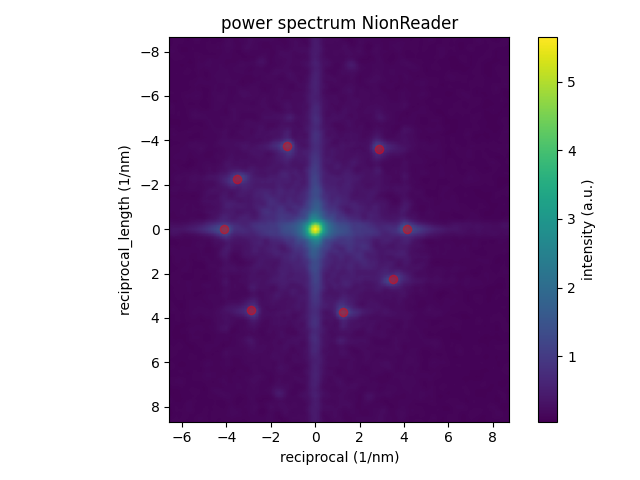

In [11]:
# ------Input----------
spot_threshold=0.12
# ---------------------

spots = it.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<8,:]
spots = spots[np.linalg.norm(spots[:,:2],axis=1)>0.5,:]
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);

## Adaptive Fourier Filter

In [42]:
#print(spots[:,:2])
print(np.round(np.linalg.norm(spots[:,:2], axis=1),2))
print(np.round(np.degrees(np.arctan2(spots[:,0], spots[:,1])+np.pi)%180,2))
angles=np.arctan2(spots[:,0], spots[:,1])
radius= np.linalg.norm(spots[:,:2], axis=1)
args = angles>0
radius = radius[angles>0]
angles = angles[angles>0]
print(radius, np.degrees(angles))

[3.95 3.95 4.12 4.12 4.16 4.16 4.63 4.63]
[ 18.43  18.43  90.    90.    57.26  57.26 141.58 141.58]
[3.95284708 4.125      4.16082924 4.62668888] [ 18.43494882  90.          57.26477373 141.58194466]


<IPython.core.display.Javascript object>


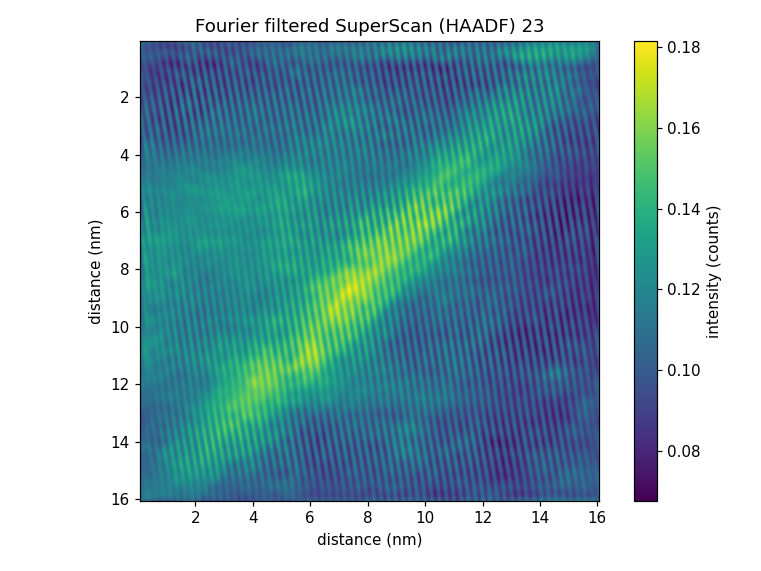

In [35]:
filtered_dataset = it.adaptive_fourier_filter(choose_image.dataset, spots, low_pass=2., reflection_radius=.3)
filtered_dataset.plot()

Let's see what we did - In Fourier space, of course.

<IPython.core.display.Javascript object>


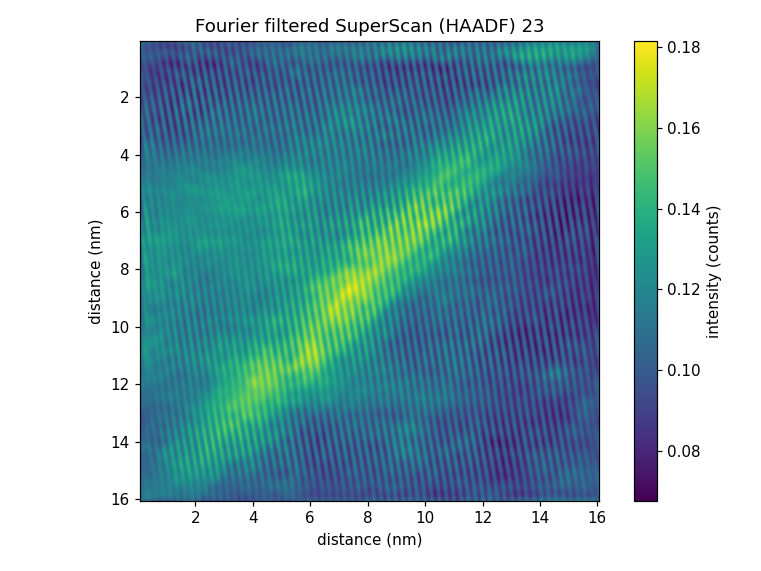

In [39]:
filtered_dataset.view.fig

In [ ]:
filtered_power_spectrum = it.power_spectrum(filtered_dataset, smoothing=0)

power_spectrum.view_metadata()
print('source: ', power_spectrum.source)
filtered_power_spectrum.plot()

Please note that the spots are ordered from center to outside.

The third parameter of a spot is its angle.

In [ ]:
print(spots[:5])

## Log the result

In [ ]:
results_channel = ft.log_results(dataset.h5_dataset.parent.parent, filtered_dataset)


A tree-like plot of the file

In [ ]:
ft.h5_tree(dataset.h5_dataset.file)

In [ ]:
dataset.h5_dataset.parent

A convenient function to select a dataset (for further processing, visualization or whatever)

In [ ]:
choose_image = ft.ChooseDataset(dataset.h5_dataset.parent.parent)

The selected dataset can then easily be plotted

In [ ]:
choose_image.dataset.plot()

## Close File
let's close the file but keep the filename

In [ ]:
filename = results_channel.file.filename
results_channel.file.close()

## Simulate new notebook
We can now simulate a new notebook and open the file again.



In [ ]:
new_dataset= ft.open_file(filename)
choose_image = ft.ChooseDataset(new_dataset.h5_dataset.parent)

In [ ]:
choose_image.dataset.plot()

We want to make an image operation of the images in the file.

In [ ]:
choose_image = ft.ChooseDataset(new_dataset.h5_dataset.parent.parent)
print('       subtract')
choose_image2 = ft.ChooseDataset(new_dataset.h5_dataset.parent)

In [ ]:
new_image = np.array(choose_image.dataset) - np.array(choose_image2.dataset)
new_image = new_dataset.like_data(new_image)
new_image.plot()

## Close File for Good

In [ ]:
new_dataset.h5_dataset.file.close()